# Import thư viện

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [8]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Đọc dữ liệu

In [9]:
def data(dataset_path):
    images = []
    labels = []
    for folder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, folder)
        for subfolder in os.listdir(subfolder_path):
            subfolder_path1 = os.path.join(subfolder_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue
            for image_filename in os.listdir(subfolder_path1):
                if image_filename.endswith(".jpg"):
                    image_path = os.path.join(subfolder_path1, image_filename)
                    images.append(image_path)
                    labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [10]:
#train
train=data('/gdrive/MyDrive/HM&UD/Doan/Skin cancer ISIC The International Skin Imaging Collaboration')
train.head()

,image,label
0,/gdrive/MyDrive/HM&UD/Doan/Skin cancer ISIC Th...,actinic keratosis
1,/gdrive/MyDrive/HM&UD/Doan/Skin cancer ISIC Th...,actinic keratosis
2,/gdrive/MyDrive/HM&UD/Doan/Skin cancer ISIC Th...,actinic keratosis
3,/gdrive/MyDrive/HM&UD/Doan/Skin cancer ISIC Th...,actinic keratosis
4,/gdrive/MyDrive/HM&UD/Doan/Skin cancer ISIC Th...,actinic keratosis


# Trực quan hóa dữ liệu

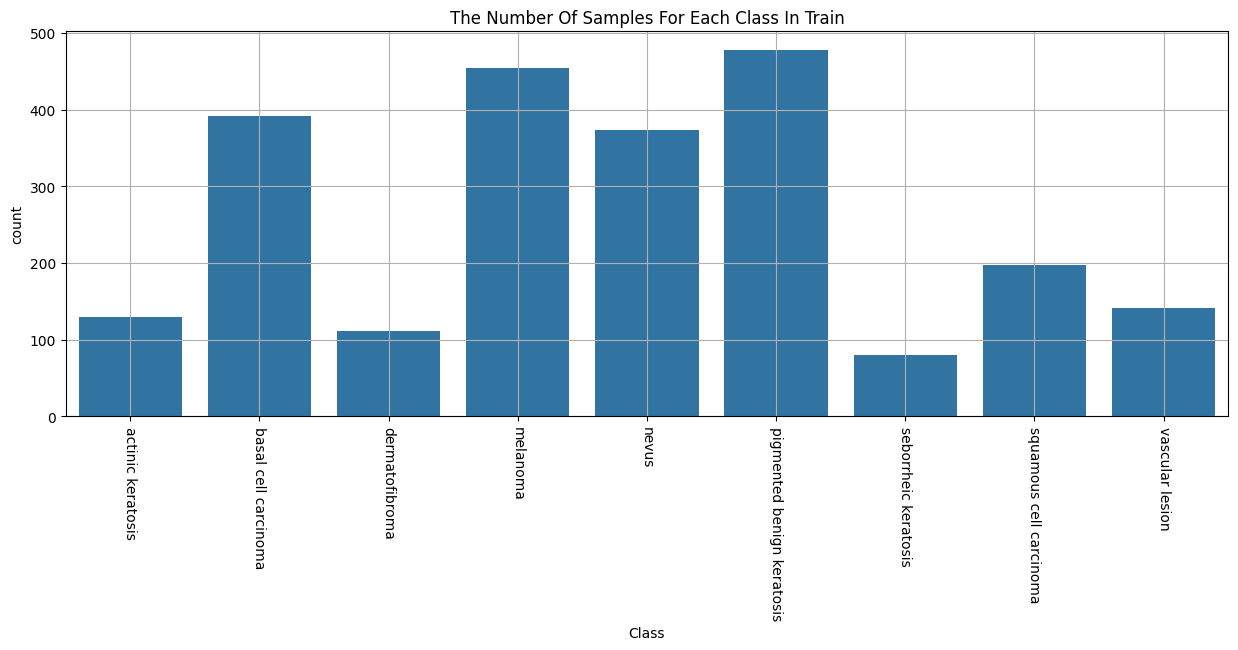

In [11]:
plt.figure(figsize=(15,5))
ax = sns.countplot(x=train.label)
ax.set_xlabel("Class")
plt.title("The Number Of Samples For Each Class In Train")
plt.grid(True)
plt.xticks(rotation=-90)
plt.show()

In [12]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

Output hidden; open in https://colab.research.google.com to view.

# Tăng cường dữ liệu

In [13]:
df_train,df_test = train_test_split(train,test_size=.2,stratify=train.label,shuffle=True,random_state=41)

In [14]:
image_size = (176, 176)
batch_size = 1700
datagen = ImageDataGenerator(
    rescale=1./255,

)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 1885 validated image filenames belonging to 9 classes.
Found 472 validated image filenames belonging to 9 classes.


In [15]:
train_iter = iter(train_generator)
train_data, train_labels = next(train_iter)

In [16]:
sm = SMOTE(random_state=41)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(3123, 176, 176, 3) (3123, 9)


In [17]:
class_num=list(train_generator.class_indices.keys())
class_num

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

<ipython-input-18-671c5a574679>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=labels,palette='Set1')


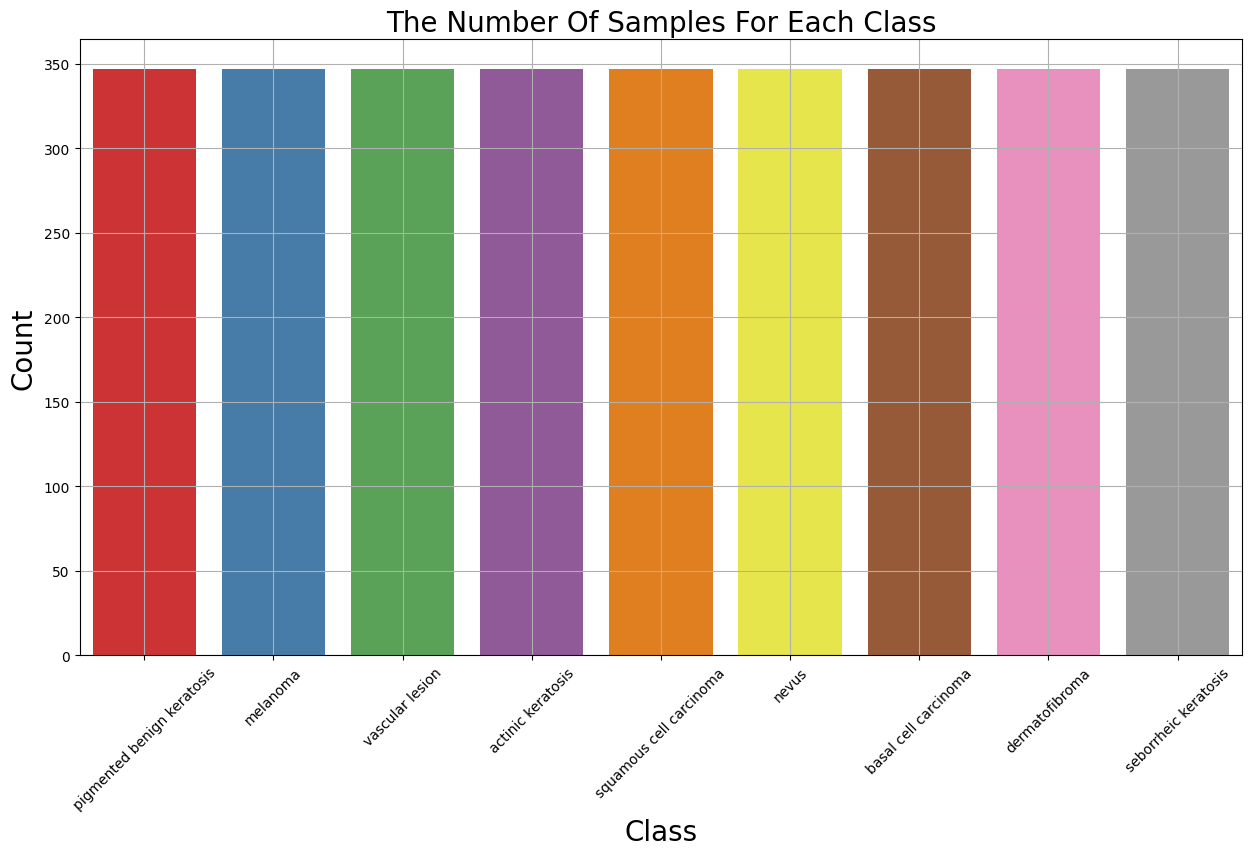

In [18]:
labels=[class_num[i] for i in np.argmax(train_labels,axis=1) ]
plt.figure(figsize=(15,8))
ax = sns.countplot(x=labels,palette='Set1')
ax.set_xlabel("Class",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
plt.title('The Number Of Samples For Each Class',fontsize=20)
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Modeling

In [19]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(176,176,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D((2,2),2,padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(9,activation='softmax'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 88, 88, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 44, 44, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 22, 22, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 6, 6, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,180,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           9,225 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,145 (4.89 MB)

 Trainable params: 1,283,145 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

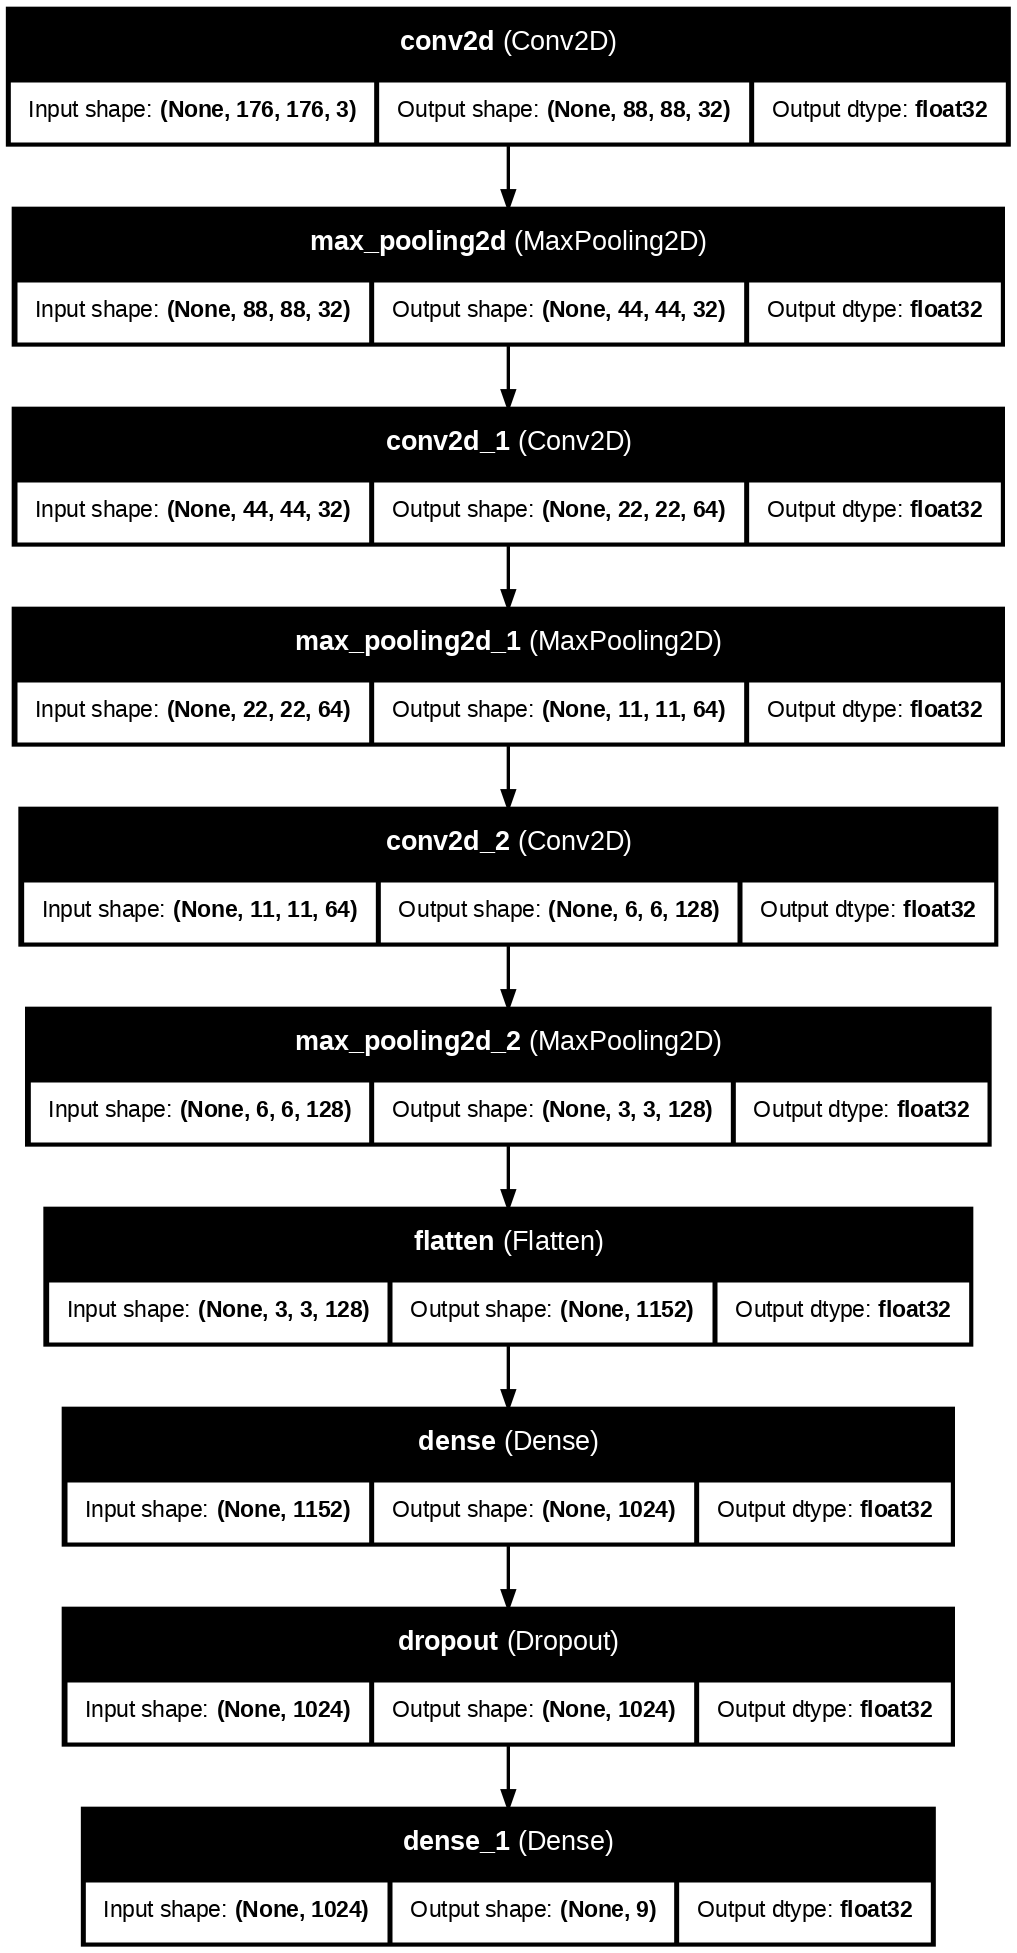

In [20]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [21]:
checkpoint_cb =ModelCheckpoint("my_keras_model.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
hist=model.fit(train_data,train_labels,validation_split=.1,epochs=50,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.1336 - auc: 0.5522 - loss: 2.1786 - specificity_at_sensitivity: 0.5054 - val_accuracy: 0.0000e+00 - val_auc: 0.1974 - val_loss: 2.9193 - val_specificity_at_sensitivity: 0.1350
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 38s 266ms/step - accuracy: 0.2811 - auc: 0.7709 - loss: 1.8063 - specificity_at_sensitivity: 0.8050 - val_accuracy: 0.0000e+00 - val_auc: 0.4069 - val_loss: 2.6596 - val_specificity_at_sensitivity: 0.3554
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 282ms/step - accuracy: 0.3538 - auc: 0.8149 - loss: 1.6538 - specificity_at_sensitivity: 0.8723 - val_accuracy: 0.2812 - val_auc: 0.7522 - val_loss: 1.8311 - val_specificity_at_sensitivity: 0.7544
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 42s 294ms/step - accuracy: 0.4290 - auc: 0.8559 - loss: 1.4896 - specificity_at_sensitivity: 0.9158 - val_accuracy: 0.5399 - val_auc: 0.9060 - val_loss: 1.1747 - val_specificity_at_sensitivity: 0.9740
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━

# Đánh giá mô hình






In [22]:
hist_=pd.DataFrame(hist.history)
hist_

,accuracy,auc,loss,specificity_at_sensitivity,val_accuracy,val_auc,val_loss,val_specificity_at_sensitivity
0,0.169395,0.614177,2.117127,0.552180,0.000000,0.197407,2.919297,0.134984
1,0.293950,0.781462,1.767641,0.833674,0.000000,0.406889,2.659640,0.355431
2,0.384697,0.829080,1.606429,0.894306,0.281150,0.752221,1.831123,0.754393
3,0.419217,0.853924,1.500626,0.911165,0.539936,0.906013,1.174707,0.974042
4,0.498221,0.883225,1.355709,0.942660,0.568690,0.923545,1.086205,0.989617
5,0.530961,0.894513,1.288226,0.949867,0.664537,0.958011,0.805286,0.999601
6,0.591103,0.919782,1.127534,0.969662,0.750799,0.966523,0.726632,0.998802
7,0.601779,0.924149,1.099150,0.969617,0.654952,0.963293,0.764859,0.996805
8,0.638790,0.937646,0.993461,0.979804,0.789137,0.984425,0.508290,1.000000
9,0.664057,0.943995,0.943198,0.980872,0.904153,0.995219,0.335667,1.000000


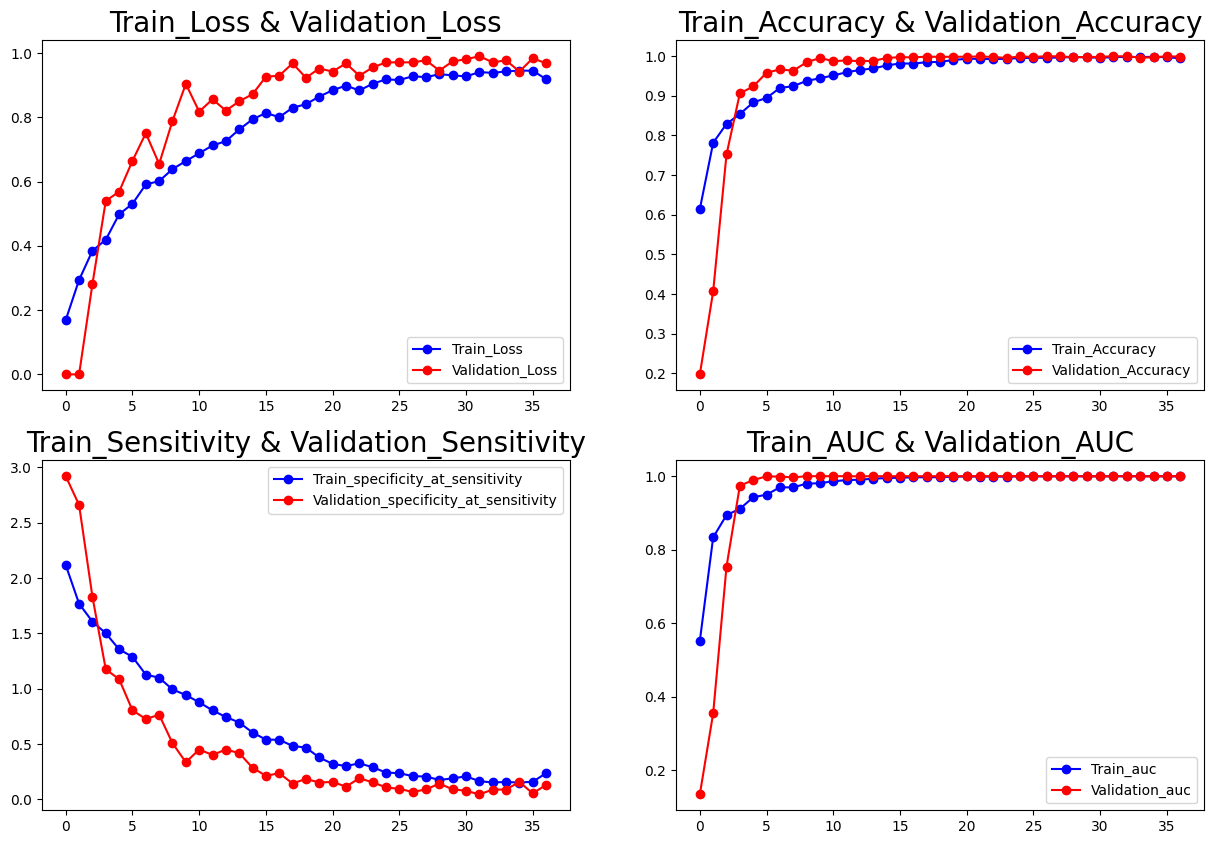

In [23]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_.iloc[:,0],'b-o',label='Train_Loss')
plt.plot(hist_.iloc[:,4],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_.iloc[:,1],'b-o',label='Train_Accuracy')
plt.plot(hist_.iloc[:,5],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_.iloc[:,2],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_.iloc[:,6],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_.iloc[:,3],'b-o',label='Train_auc')
plt.plot(hist_.iloc[:,7],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [24]:
score, acc,sensitivity,auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5297 - auc: 0.8561 - loss: 2.5124 - specificity_at_sensitivity: 0.9526
Test Loss = 2.512362003326416
Test Accuracy = 0.5296609997749329
Test Sensitivity = 0.9525953531265259
Test AUC = 0.8560981154441833


<a id="7"></a>
# <p style="background-image: url(https://i.postimg.cc/K87ByXmr/stage5.jpg);font-family:camtasia;font-size:120%;color:white;text-align:center;border-radius:15px 50px; padding:7px"> Modeling </p>
<a class="btn" href="#home">Tabel of Contents</a>

In [25]:
base_model = tf.keras.applications.DenseNet121(
    input_shape=(176, 176, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
inputs = tf.keras.Input(shape=(176, 176, 3))
x = base_model(inputs, training=False)
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(9, activation='softmax')(x)
model2 = keras.models.Model(inputs, outputs)
model2.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 176, 176, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 5, 5, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │         230,409 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,267,913 (27.72 MB)

 Trainable params: 230,409 (900.04 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

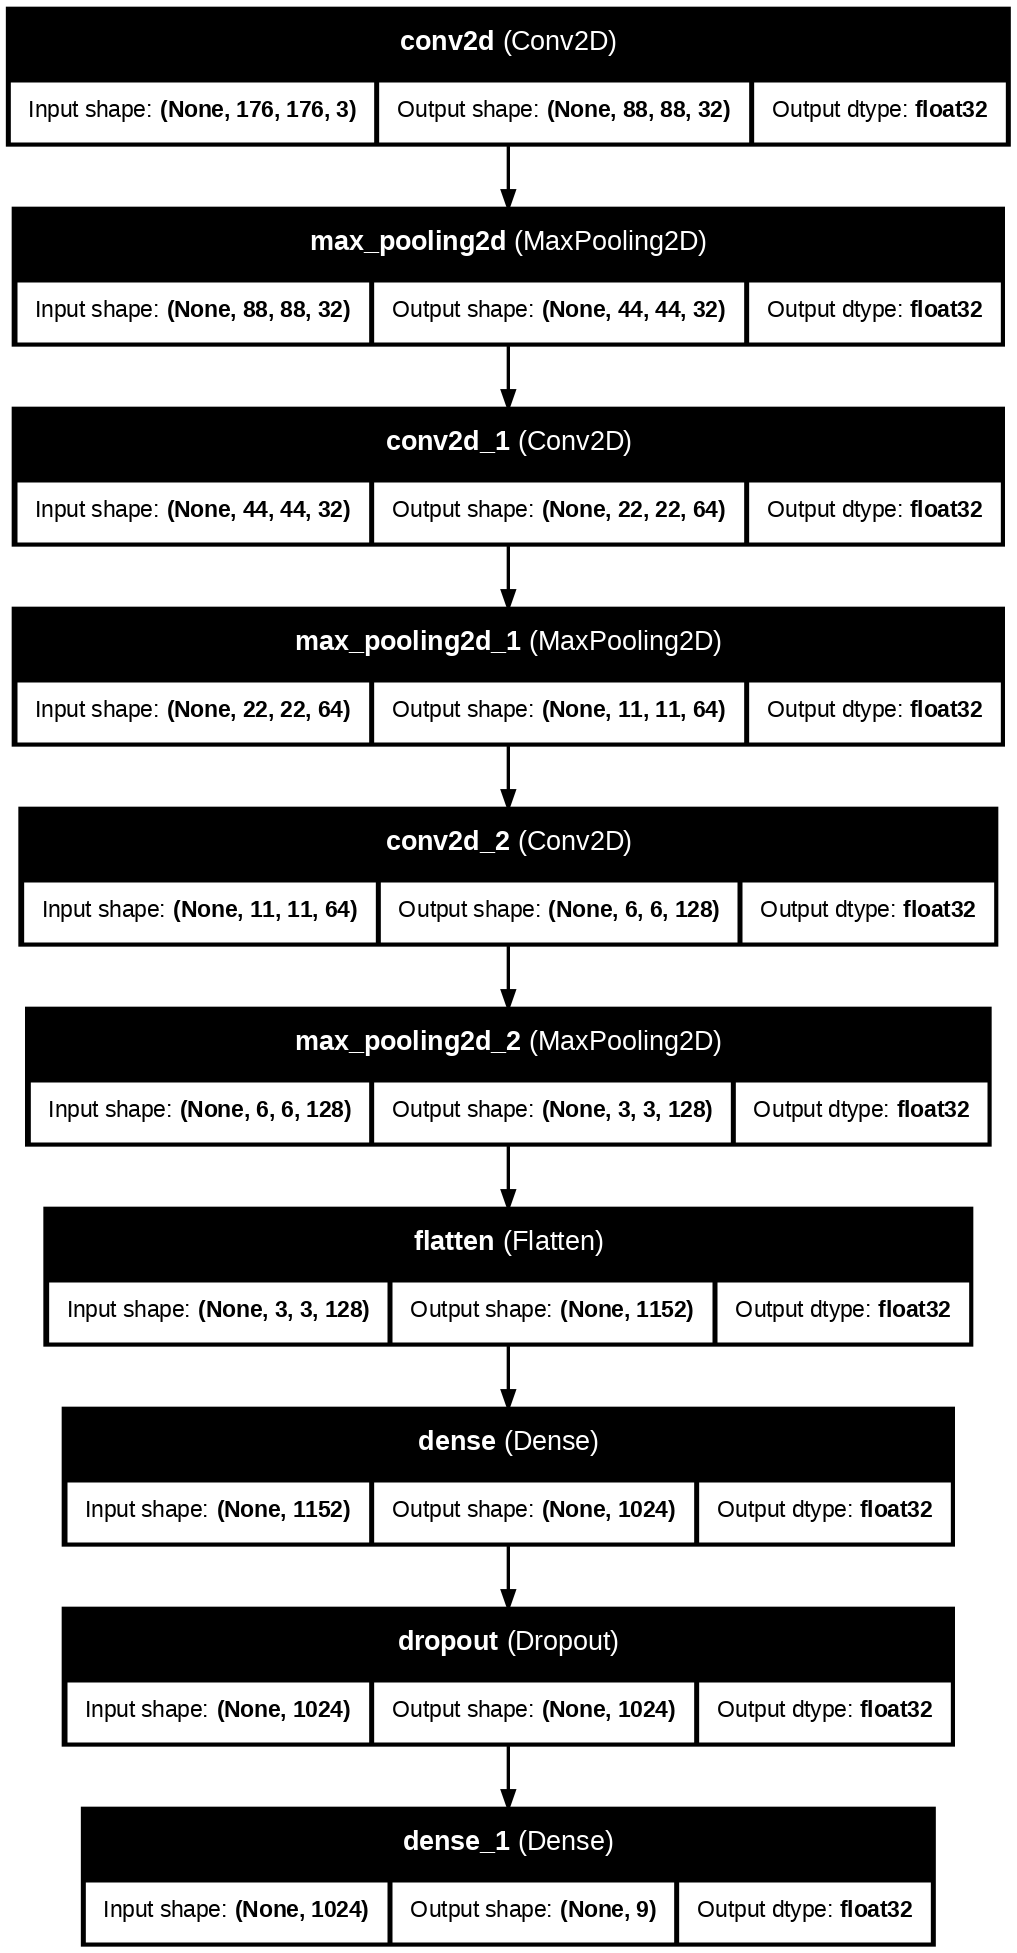

In [26]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [27]:
checkpoint_cb =ModelCheckpoint("my_keras_model2.keras", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model2.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
hist=model2.fit(train_data,train_labels,validation_split=.1,epochs=50,callbacks=[checkpoint_cb,early_stopping_cb])

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.3625 - auc_1: 0.7403 - loss: 2.6648 - specificity_at_sensitivity_1: 0.8309 - val_accuracy: 0.8850 - val_auc_1: 0.9801 - val_loss: 0.4276 - val_specificity_at_sensitivity_1: 1.0000
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - accuracy: 0.6759 - auc_1: 0.9301 - loss: 1.1285 - specificity_at_sensitivity_1: 0.9845 - val_accuracy: 0.8466 - val_auc_1: 0.9737 - val_loss: 0.5316 - val_specificity_at_sensitivity_1: 0.9996
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 377s 4s/step - accuracy: 0.7269 - auc_1: 0.9499 - loss: 0.9273 - specificity_at_sensitivity_1: 0.9913 - val_accuracy: 0.8466 - val_auc_1: 0.9659 - val_loss: 0.6565 - val_specificity_at_sensitivity_1: 0.9976
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 384s 4s/step - accuracy: 0.7623 - auc_1: 0.9597 - loss: 0.8426 - specificity_at_sensitivity_1: 0.9942 - val_accuracy: 0.8307 - val_auc_1: 0.9607 - val_loss: 0.6996 - val_specificity_at_sensitivity_1: 0.9960
Epoch 5/50
88/88 ━━━

# Evaluate The Model

In [28]:
hist_=pd.DataFrame(hist.history)
hist_

,accuracy,auc_1,loss,specificity_at_sensitivity_1,val_accuracy,val_auc_1,val_loss,val_specificity_at_sensitivity_1
0,0.454448,0.811897,2.211183,0.918950,0.884984,0.980050,0.427588,1.000000
1,0.692883,0.931669,1.107837,0.986077,0.846645,0.973695,0.531560,0.999601
2,0.743772,0.953005,0.894018,0.991548,0.846645,0.965878,0.656470,0.997604
3,0.764769,0.954934,0.895929,0.992215,0.830671,0.960706,0.699552,0.996006
4,0.816370,0.971753,0.653159,0.995774,0.929712,0.987555,0.286385,1.000000
5,0.819217,0.970451,0.664606,0.996263,0.904153,0.986544,0.395126,0.998003
6,0.853737,0.976844,0.560027,0.997020,0.916933,0.988975,0.307512,0.998403
7,0.851601,0.977613,0.541240,0.997153,0.926518,0.993248,0.220959,1.000000
8,0.870463,0.981282,0.500940,0.997776,0.952077,0.997324,0.145801,0.999601
9,0.867260,0.981648,0.484013,0.997998,0.929712,0.988882,0.277456,0.998802


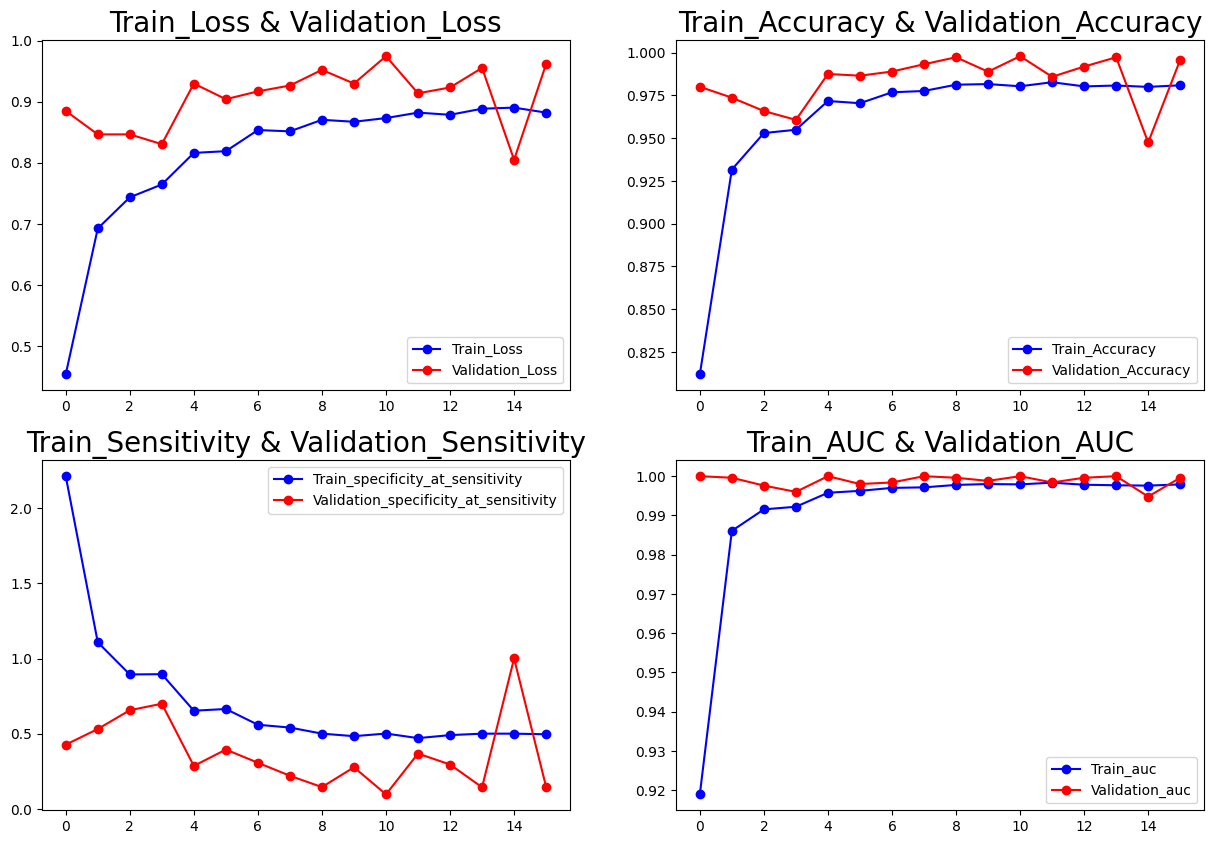

In [29]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_.iloc[:,0],'b-o',label='Train_Loss')
plt.plot(hist_.iloc[:,4],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_.iloc[:,1],'b-o',label='Train_Accuracy')
plt.plot(hist_.iloc[:,5],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_.iloc[:,2],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_.iloc[:,6],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_.iloc[:,3],'b-o',label='Train_auc')
plt.plot(hist_.iloc[:,7],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [30]:
score, acc,sensitivity,auc = model2.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 84s 84s/step - accuracy: 0.5191 - auc_1: 0.8295 - loss: 3.2657 - specificity_at_sensitivity_1: 0.9460
Test Loss = 3.265688180923462
Test Accuracy = 0.5190678238868713
Test Sensitivity = 0.945974588394165
Test AUC = 0.8294999599456787


# Kiểm tra mô hình

In [31]:
y_test =test_generator.classes
predictions = model2.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

1/1 ━━━━━━━━━━━━━━━━━━━━ 74s 74s/step


,Actual,Prediction
0,5,5
1,4,0
2,4,5
3,3,3
4,8,8
...,...,...
467,5,5
468,3,4
469,5,8
470,6,3


In [32]:
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_num[int(y_test[n])],fontsize=25)

Output hidden; open in https://colab.research.google.com to view.

array([[ 4,  3,  1,  1,  9,  5,  0,  3,  0],
       [ 1, 44,  2,  9,  4, 11,  0,  7,  1],
       [ 0,  1,  7,  5,  2,  3,  0,  2,  2],
       [ 1,  1,  0, 64,  8,  4, 13,  0,  0],
       [13,  1,  0, 20, 35,  4,  1,  0,  1],
       [ 2,  9,  2, 10, 10, 56,  0,  3,  4],
       [ 0,  0,  0, 15,  0,  0,  1,  0,  0],
       [ 3,  8,  2,  3,  0, 11,  0, 11,  1],
       [ 0,  1,  0,  2,  0,  2,  0,  0, 23]])

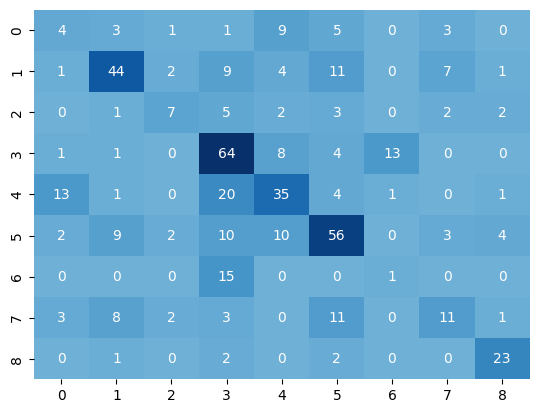

In [33]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [34]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.17      0.15      0.16        26
           1       0.65      0.56      0.60        79
           2       0.50      0.32      0.39        22
           3       0.50      0.70      0.58        91
           4       0.51      0.47      0.49        75
           5       0.58      0.58      0.58        96
           6       0.07      0.06      0.06        16
           7       0.42      0.28      0.34        39
           8       0.72      0.82      0.77        28

    accuracy                           0.52       472
   macro avg       0.46      0.44      0.44       472
weighted avg       0.52      0.52      0.51       472



In [35]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpvvyleh9p'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 176, 176, 3), dtype=tf.float32, name='keras_tensor_483')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  138942046346704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138942046354272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138942046347056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138942046350048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138942046348464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138942046553184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138942046561808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138942046559520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138942046560224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138942046565680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1389420465